<h1><center>Diplomado de Ciencias de Datos - Trabajo Final - Octubre 2021</center></h1> 
<h2><center>Caso Práctico: Sistema Provincial de Expedientes (SIE)</center></h2> 
<h3><center>2° Parte</center></h3>
<h4><center>Ing. Romina C. Scarazzini</center></h4>

___
# Contenido
- Limpieza de Datos con Power BI: Para ver el detalle de lo realizado en este paso, ver el documento: "Limpieza de Datos con Power BI.pdf"
- Exploración  y análisis de los datos (EDA)
- **Análisis de las características de Series Temporales**
- Aplicación de modelos de Machine Learning, enfocados a Series Temporales
- Predicciones 2021

___
# Importación de Paquetes

In [1]:
# Instalación de paquetes para tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Instalación de paquetes para gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Declaración del estilo
plt.style.use("bmh")                     
    
# Configuración del tamaño de las visualizaciones para que se muestren bien en Jupyter
plt.rcParams["figure.figsize"] = 16, 5 

# Configuración Warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Instalación de Paquetes de Statsmodels
Statsmodels es un módulo de Python que proporciona clases y funciones para la estimación de muchos modelos estadísticos diferentes, así como para realizar pruebas estadísticas y exploración de datos estadísticos.

In [2]:
# Para determinar la autocorrelación de una serie de tiempo
import statsmodels.graphics.tsaplots as sgt 

# Contiene la prueba de "Dickey Fuller" para saber si nuestra serie de tiempo es o no estacionaria
import statsmodels.tsa.stattools as sts 

# Análisis de estacinalidad clásicia: Descomposición de estacionalidad aditiva
from statsmodels.tsa.seasonal import seasonal_decompose

# Método de Godric Prescott que nos permite descomponer la serie en dos componentes: la tendencia y lo cíclico 
from statsmodels.tsa.filters.hp_filter import hpfilter

## Instalación de Paquetes de SkLearn

In [3]:
# Evaluación de Modelos: Error cuadrático medio: Mean Squared Error (MSE)
# Estima errores en las predicciones de los modelos 
#========================================================
from sklearn.metrics import mean_squared_error

___
# Recupero los dataset trabajados en la 1° Parte del trabajo

In [4]:
# Defino como índice la 1° columna y diciendo que es una fecha
#======================================================================
df_total = pd.read_csv("df_total.csv", sep=';', index_col=0, parse_dates=True)
df_Week = pd.read_csv("df_Week.csv", sep=';', index_col=0, parse_dates=True)
df_total.head()

,Cant_Expte
Fecha_Ini_Expte,
2011-01-03,1144.0
2011-01-04,1217.0
2011-01-05,1326.0
2011-01-06,1377.0
2011-01-07,1388.0


___
# Características de una Serie de tiempo
## Ruido Blanco
- El ruido blanco es un tipo especial de serie temporal donde los datos van a depender del tiempo, pero no van a seguir ningún patrón
- En el ruido blanco lo que ocurre es que no encontramos ningún patrón, entonces no se puede predecir el futuro es decir un ruido blanco es una serie temporal que no tiene ningún patrón y cuyo futuro además no es predecible
- Para que una serie se pueda considerar como ruido blanco necesita satisfacer las siguientes tres condiciones:
  - No tener una media constante 
  - No tener una varianza constante
  - No tener auto correlaciones en ningún período (mide cuan correlacionada es una serie con versiones anteriores de sí misma)
- Es importante distinguir los datos con ruido blanco de los datos de series temporales regulares. Podemos distinguir fácilmente los dos comparando sus gráficos

In [5]:
# Genero una variable con ruido blanco. Ruido blanco es una serie temporal que 
rb = np.random.normal(loc = df_Week.Cant_Expte.mean(), scale = df_Week.Cant_Expte.std(), size = len(df_Week))

In [6]:
#Agrego el ruido blanco al dataset
#======================================
df_Week['rb'] = rb
df_Week.describe()

,Cant_Expte,rb
count,521.000000,521.000000
mean,6475.568138,6463.641014
std,1689.863199,1747.614054
min,234.000000,1342.141281
25%,5354.000000,5269.801030
50%,6672.000000,6418.866477
75%,7767.000000,7691.717496
max,11335.000000,12040.300347


### Gráfico: Ruido Blanco y la Serie de Tiempo
Configuro ambos gráficos con la misma magnitud en el eje para poder compararlos visualmente

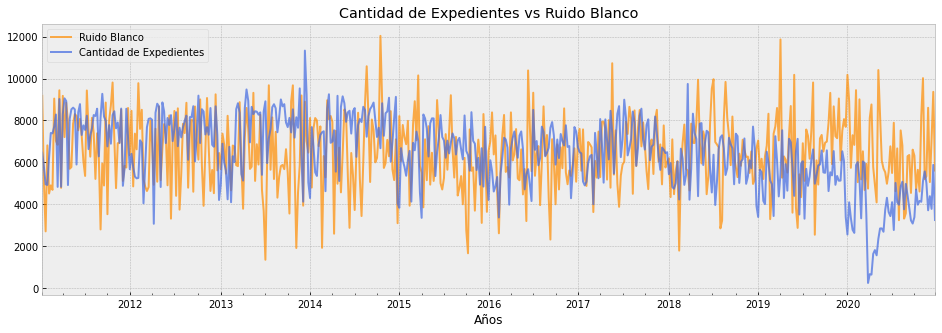

In [7]:
#Grafico el El Ruido Blanco y la Serie de Tiempo
#====================================================
fig, ax=plt.subplots()
df_Week['rb'].plot(ax=ax, label='Ruido Blanco',color="darkorange", alpha=0.7)
df_Week['Cant_Expte'].plot(ax=ax, label='Cantidad de Expedientes', color="royalblue", alpha=0.7)
plt.title("Cantidad de Expedientes vs Ruido Blanco")
plt.xlabel("Años")
ax.legend();

#### Conclusiones
Mirando ambos gráficos, se observa la diferencia entre lo que es nuestra serie temporal con patrones (azul) y lo que es una serie temporal sin ningún patrón (amarillo), con la cual no se puede predecir lo que va a pasar en un futuro

___
# Caminata Aleatoria
- Una caminata aleateoria en un tipo especial de serie de tiempo donde los valores tienden a persistir en el tiempo y las diferencias entre períodos son simplemente ruido blanco
- Si llamamos "CE" a la Cantidad de Expedinetes, "RE" a los Residuos y con la letra "t" indicamos un perído específico, entonces: CE(t) = CE(t-1) + RE(t)

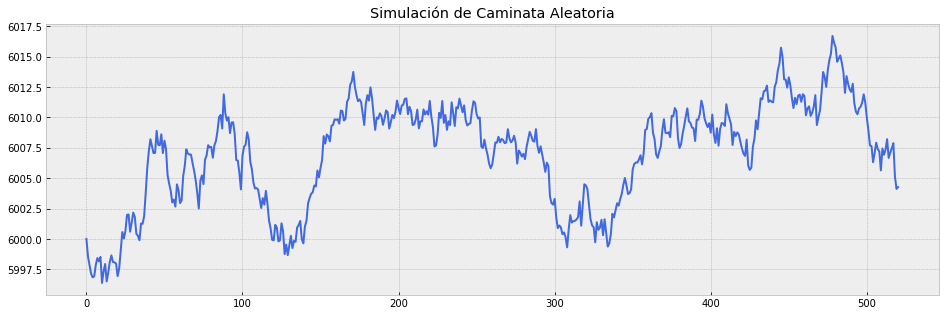

In [8]:
# Generamos 500 pasos aleatorios para la caminara aleatoria, con media (loc) 0 y desv (scale) 1, tamaño de la serie: 2086
#===================================================================================
steps = np.random.normal(loc=0, scale=1, size=521)
 
# Ponemos el primer elemento a 0 para que el valor inicial sea el que pongamos nosotros
steps[0]=0
 
# Simulando los valores ca con un valor inicial de 1500
ca = 6000 + np.cumsum(steps)
 
# Plot
plt.plot(ca, color="royalblue")
plt.title("Simulación de Caminata Aleatoria");
#plt.ylim(0,3500);

In [9]:
# Agrego los datos de la caminata aleatoria en dataset
#========================================================
df_Week['ca'] = ca

## Gráfico: Caminta Aleatoria y Serie de Tiempo

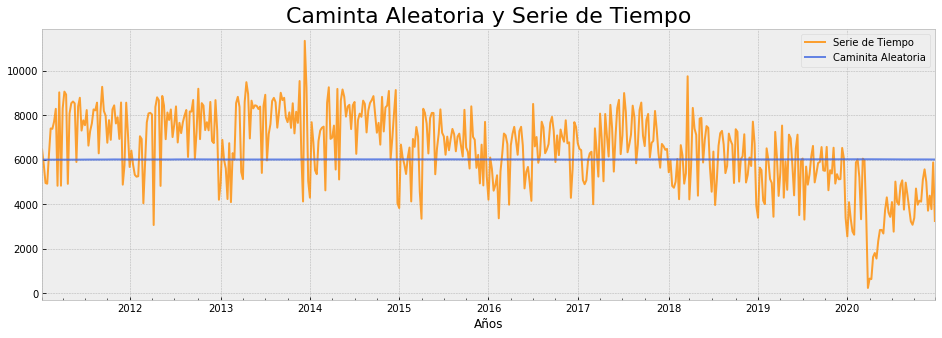

In [10]:
fig, ax=plt.subplots()
df_Week['Cant_Expte'].plot(ax=ax, label='Serie de Tiempo', color="darkorange", alpha=0.8)
df_Week['ca'].plot(ax=ax, label='Caminita Aleatoria',color="royalblue", alpha=0.8)
plt.title("Caminta Aleatoria y Serie de Tiempo", fontsize=22)
plt.xlabel("Años")
ax.legend();

___
# Estacionariedad - Series Estacionarias (Stationarity)
- Una serie de tiempo es estacionaria, cuando es estable a lo largo del tiempo
## Estacionariedad Débil
- Cuando la media y la varianza son constantes en el tiempo y además no presenta tendencias
- Esto se refleja gráficamente en que los valores de la serie tienden a oscilar alrededor de la media constante y la variabilidad con respecto a esa media también permanece constante en el tiempo 
- Entonces una serie no estacionaria es aquella cuya tendencia y o variabilidad cambian en el tiempo o sea no permanecen constantes
## Estacionariedad en Convarianza
- A la propiedad anterior agregamos los siguiente: si tomamos dos secuencias de datos consecutivas (cada una con la misma cantidad de datos), aunque el punto inicial sea diferente, si la serie es estacionaria entonces estas dos secuencias tendrán la misma covarianza, independientemente del punto de partida
## Estacionariedad Estrcita
- A los dos propiedad anteriores agregamos lo siguiente: si tomamos dos secuencias de datos consecutivas (cada una con la misma cantidad de datos), aunque el punto inicial sea diferente, si la serie es estacionaria estricta entonces estas dos secuencias tendrán la misma distrubición, independientemente del punto de partida

La Estacionariedad Estrcita es muy poco usual, por lo que se acepta universalmente poder usar la definición de **"Estacionariedad en Covarianza"** o **"Estacionariedad Débil"** como definición de estacionariedad

## Método para verificar si una serie es o no Estacionaria
- El método para verificar si un conjunto de datos proviene de un proceso estacionario o no, se conoce como la prueba **Dickey Fuller** o prueba de F
- La inferencia es la parte de la estadística que aborda el problema de cómo extender las características de una muestra al proceso que la generó, y esto nos permite estudiar ese proceso en base a la muestra que tenemos
- Los contrastes de hipótesis son uno de los métodos que se utilizan para hacer inferencia
- Los contrastes consisten en contrastar unas hipótesis. Por lo cual, vamos a tener una hipótesis nula y una hipótesis alternativa
- Si luego del analisis hay suficiente evidencia en contra de la hipótesis nula, entonces se rechaza la hipótesis nula
- En nuestro caso tenemos:
  - Hipótesis nula: la serie no es Estacionaria
  - Hipótesis alternativa: la serie es Estacionaria

## Método de "Dickey Fuller"

In [11]:
# Aplicamos la prueba de "Dickey Fuller" para saber si nuestra serie de tiempo es o no estacionaria
#==================================================================================================
sts.adfuller(df_Week.Cant_Expte)

(-3.4680912438992038,
 0.008845406138971508,
 4,
 516,
 {'1%': -3.443086684769254,
  '5%': -2.867157550015396,
  '10%': -2.5697619453458325},
 8553.715739796547)

#### Conclusiones
- Tenemos un P valor de: "0.005466977390414817", el cual es mucho menor que los niveles de significación: 1%, 5% y 10%. Esto quiere decir que hay evidencia significativa para identificar esta serie temporal como estacionaria, ya que con esto podemos rechazar a la hipótesis nula
- Además, mirando el valor del "Estadístico de Constraste" o "Estadístico de Prueba": "-3.6157492097353674" y comparándolo con los valores críticos: "3.4328822265006687", "-2.862658740388024" y "-2.5673655460943023", vemos que es menor a dichos valores
- Así que llegamos a la conclusión que nuestra serie **es una serie con Estacionariedad**

___
# Estacionalidad (Seasonality)
- La estacionalidad sugiere que ciertas tendencias van a aparecer en nuestra serie temporal de forma cíclica
- Por ejemplo las temperaturas suben y bajan según las horas del día, si es de día o si es de noche, no es la misma temperatura y esto casi siempre es así, es cíclico, siempre es el mismo patrón.
- También cambia según los meses del año no es la misma temperatura en primavera, verano, otoño, o invierno pero de año en año se mantienen los mismos patrones
- Hay varias formas de comprobar si existe estacionalidad. Un enfoque es descomponer la serie en tres efectos que van a ser:
  - El efecto de tendencia: representa la presencia de un patrón consistente en nuestro datos
  - El efecto estacional: va a expresar todos los efectos cíclicos debido a la estacionalidad
  - El efecto residual: los residuos son el error de predicción o la diferencia entre los datos reales y el modelo que estamos ajustando

- El tipo más simple de descomposición es la descomposición clásica, con ella esperamos una relación lineal entre las tres partes de la serie de tiempo observada
- La descomposición clásica va a consistir en dos enfoques:
  - Enfoque aditivo: para un periodo de tiempo "t" el valor observado de la serie temporal es la suma de la tendencia más el efecto estacional más el efecto residual para ese período **(T(t)+E(t)+R(t))**. Se usa este modelo cuando la serie tiene un compartamiento lineal, por ejemplo cada año se agregan 10.000 expedientes aproximadamente
  - Enfoque multiplicativo: Aquí se considera la multiplación de la valoreas mencionados: **(T(t)xE(t)xR(t))**. Se usa este modelo cuando la serie tiene un compartameinto no lineal, por ejemplo cada año se agrega el doble de expedientes aproximadamente  

## Descomposición de Estacionalidad Aditiva

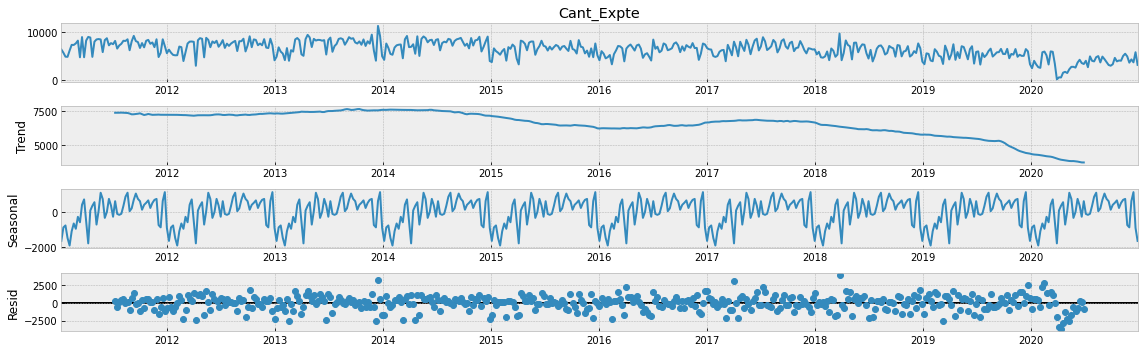

In [12]:
# Análisis de estacinalidad clásicia: Descomposición de estacionalidad aditiva
#==================================================================================
de_aditiva = seasonal_decompose(df_Week.Cant_Expte, model = "additive")
de_aditiva.plot();

#### Conclusiones
- En el primer gráfico vemos la serie de tiempo sin descomponer
- Luego están los gráficos de los tres componentes de la descomposición: efecto de tendencia, efecto estacional y el efecto residual residual
  - El gráfico de tendencia se parece mucho a la serie observada. Esto se debe a que la función de descomposición utiliza los valores del período anterior como un marcador de tendencia. Esta gráfico explica la mayor parte de la variabilidad de los datos
  - El gráfico del componente estacional se parece a un rectángulo, esto sucede cuando los valores oscilan constantemente de un lado a otro y el tamaño de la figura es demasiado pequeño y no podemos ampliarla como en otros tipos de gráficos. Como cambia constantemente de arriba abajo entre 0,95 y 1 podemos decir que no hay un patrón cíclico concreto
  - El gráfico de residuos muestra los errores de las estimaciones del modelo. Son la diferencia entre los valores verdaderos y las predicciones del modelo para cualquier período
- Entonces vemos que en general los resultados de la descomposición aditiva sugieren que **no hay estacionalidad** en los datos

## Descomposición de Estacionalidad Multiplicativa

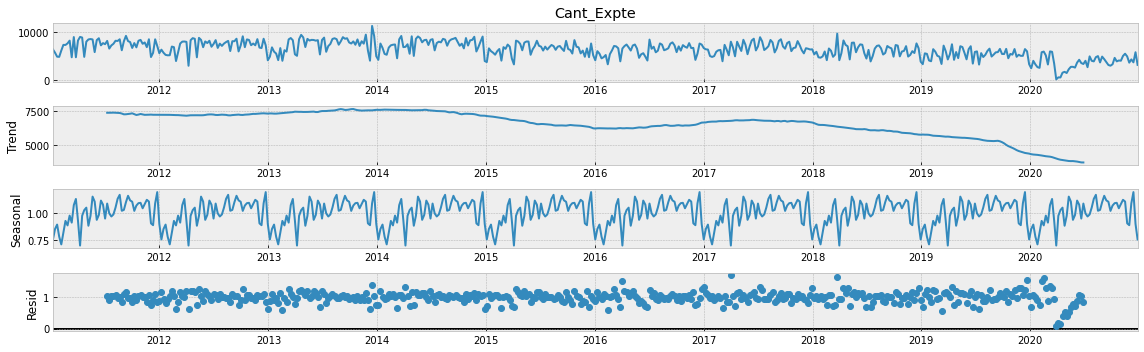

In [13]:
# Análisis de estacinalidad clásicia: Descomposición de estacionalidad multiplicativa
#====================================================================================
de_multiplicata = seasonal_decompose(df_Week.Cant_Expte, model = "multiplicative")
de_multiplicata.plot();

#### Conlusiones
- Los gráficos muestran resultados similares a la primera descomposición. Es decir no hay un patrón claro en la parte estacional y la tendencia se parece mucho a la serie observada
- Por lo tanto tenemos otra prueba más de que **no hay estacionalidad** en nuestra serie de tiempo

___
# Descomposición de la serie en: componente de tendencia y componente cíclico 
### Método de Godric Prescott
- Este método que nos va a permitir descomponer la serie en dos componentes: un componente de tendencia y un componente cíclico 
- Es decir, para cada periodo va a considerar que el valor de mi serie es igual a dos componentes: Tendencia + Cíclico: X(t) = T(t) + C(t)
- Esto va a depender de un parámetro Landa, el cual va a medir las variaciones en la tasa de crecimiento del componente de tendencia. Aunque aquí en el modelo no aparezca, luego aparece en la función de coste que minimiza este método
- Para hallar esta descomposición el método lo que hace es minimizar una función cuadrática donde aparece el Landa
- Landa puede ser interpretado como un parámetro de suavizado
- Entonces cuando se minimiza esa ecuación hay que fijar el valor de Lamba
- En Python el valor de Landa viene por defecto, según el perído de la serie de tiempo

Con el método de "Godric Prescott", podemos a partir del efecto de tendencia del gráfico anterior, separarlo en efecto de tendencia y efecto cíclico

In [14]:
# Aplicamos el método Godric Prescott a nuestra serie de tiempo
# El valor de Lamba para una serie de tiempo con períodos anuales es de: 1600
#============================================================================
gdp_ciclo, gdp_trend = hpfilter(df_Week['Cant_Expte'], lamb=1600)

In [24]:
#Agregamos la tendencia y el cliclo de la serie al dataset
#========================================================
df_Week['tend'] = gdp_trend
df_Week['ciclo'] = gdp_ciclo

# Armo dataframe con la tendencia
#=======================================================
variables= ['tend']
df_Tend = pd.DataFrame(df_Week, columns=variables)
df_Tend = df_Tend.rename(columns={'tend': 'Cant_Expte'})
df_Tend.to_csv('df_Tend.csv', sep=';')
df_Tend.head()

,Cant_Expte
Fecha_Ini_Expte,
2011-01-09,5960.575560
2011-01-16,6091.158324
2011-01-23,6222.048853
2011-01-30,6353.352938
2011-02-06,6484.380091


In [21]:
df_Week.head()

,Cant_Expte,rb,ca,tend,ciclo
Fecha_Ini_Expte,,,,,
2011-01-09,6453,6014.300288,6000.000000,5960.575560,492.424440
2011-01-16,5768,7816.696936,6000.025010,6091.158324,-323.158324
2011-01-23,4948,4036.778564,6000.658647,6222.048853,-1274.048853
2011-01-30,4917,5508.231382,5999.950468,6353.352938,-1436.352938
2011-02-06,6222,4728.752075,5999.100005,6484.380091,-262.380091


### Gráfico: Tendencia separada de la Serie Temporal

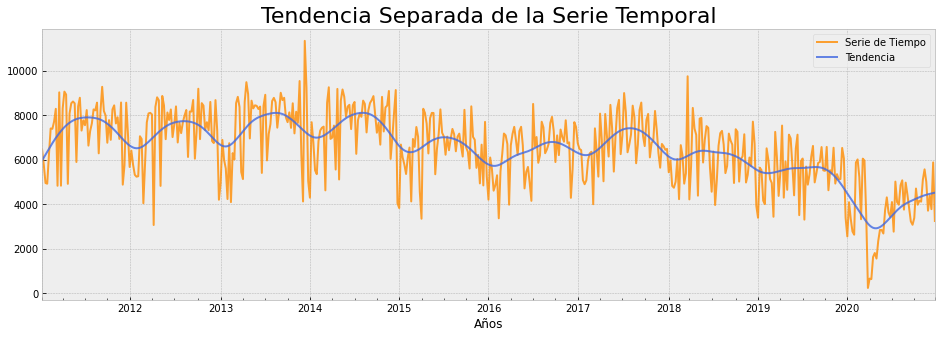

In [18]:
fig, ax=plt.subplots()
df_Week['Cant_Expte'].plot(ax=ax, label='Serie de Tiempo', color="darkorange", alpha=0.8)
df_Week['tend'].plot(ax=ax, label='Tendencia',color="royalblue", alpha=0.8)
#df_Week['ciclo'].plot(ax=ax, label='Ciclo',color="firebrick", alpha=0.8)
plt.title("Tendencia Separada de la Serie Temporal", fontsize=22)
plt.xlabel("Años")
ax.legend();

#### Conclusiones
- Observamos que los valores reales resultan estar por encima o por debajo de los valores de la tendencia
- Vemos que el gráfico de la tendencia aquí es similar a la tendencia del gráfico anterior, ya que como ya habíamos concluido, en realidad esta serie no tiene componente cíclico, es decir que **no tiene estacionalidad**

___
# Autocorrelación
- Autocorrelación porque es consigo misma, es la correlación entre una secuencia y si misma
- Más precisamente mide el nivel de semejanza entre una secuencia de hace varios períodos atrás y el period actual
- Esta secuencia de varios períodos atrás, se va a llamar retraso y "k" es exactamente el retraso de cuantos períodos se va a ir hacia atrás
- Lo cual seria: **corr(X(t)-X(t-k))**
- En las series temporales va a ser vital poder calcular y comparar los valores de autocorrelación entre diferentes retrasos
- Es necesario introducir la función de autocorrelación o ACF. Esta función de autocorrelación nos va a proporcionar la autocorrelación para cualquier retraso que consideremos

## Autocorrelación de Nuestra Serie Temporal
- Aplicamos el método **sgt** del paquete **Statsmodels** en Python para determinar la autocorrelación de nuestra serie

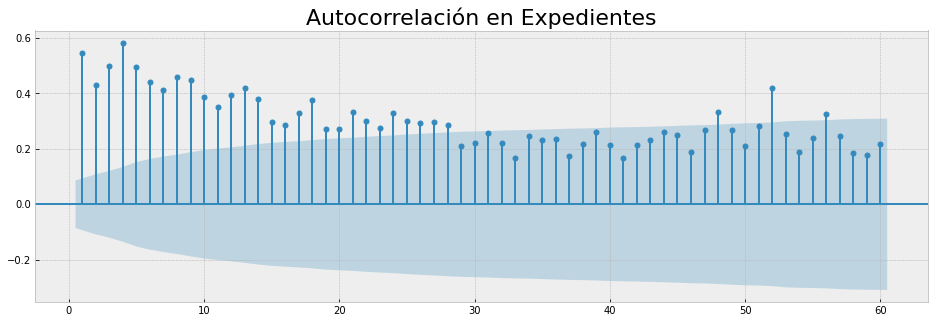

In [23]:
# El parámetro "lags" son los retrazos. Se usna 260 lags que equivale a 1 año en días laborales
# El parámetro "zero = False", indica que no vamos a incluir el valor del período actual en el gráfico para la función de autocorrelación. 
#Es innecesario hacer esta inclusión en un gráfico porque la correlación entre un valor en sí mismo siempre va a ser uno
#================================================================================
sgt.plot_acf(df_Week.Cant_Expte, lags = 60, zero = False)
plt.title("Autocorrelación en Expedientes", size = 22);

#### Conculsiones
- Cada línea del gráfico va a representar la autocorrelación entre nuestra serie de tiempo y una versión retrasada de sí misma
- Por ejemplo la primera línea indica la autocorrelación con retraso de un periodo de tiempo
- La segunda línea indica la autocorrelación para hace dos períodos y así sucesivamente
- Como los períodos son días tendríamos el retraso con respecto al día anterior y con respecto a dos días y con respecto a tres días y así sucesivamente
- El área azul alrededor del eje X representa la significación de los valores de autocorrelación. Es decir mide si son significativamente distinto de cero lo que sugiere la existencia de autocorrelación para ese retraso específico. Vamos a observar cómo se expande esta área va de mas chica a más grande, esto es porque a mayor distancia en el tiempo más improbable será que la correlación persista
- El coeficiente de autocorrelación en los retrasos más antiguos no son suficientemente mayores para que sean significativamente diferente de cero
- Observemos también cómo todas las líneas, hasta el vaor 140, son más altas que la región azul. Esto sugiere que los coeficientes son significativos por lo que es un indicador de la dependencia del tiempo en los datos
- Podemos ver también que la autocorrelación disminuye en la medida que aumentan los retrazos

## Autocorrelación del Ruido Blanco 
- Ahora vamos a estimar la función de autocorrelación de la serie de ruido blanco que generamos anteriormente
- Poder distinguir el ruido blanco de los datos de series temporales regulares es fundamental en el modelado

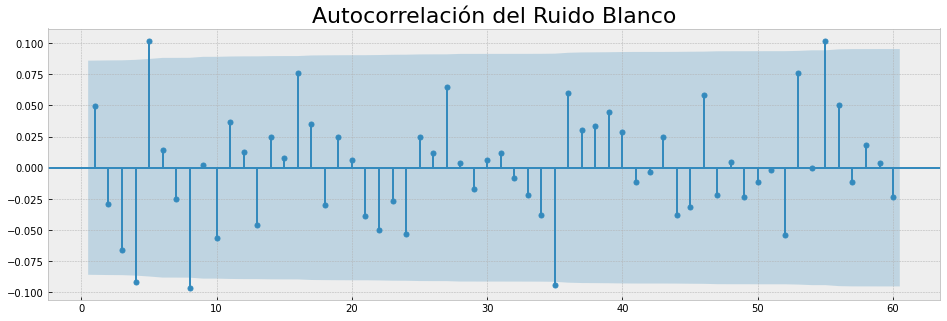

In [24]:
sgt.plot_acf(df_Week.rb, lags = 60, zero = False)
plt.title("Autocorrelación del Ruido Blanco", size = 22);

#### Conclusiones
- Tenemos valores que cambian en ambos sentidos tanto positivos como negativos esto contrasta con el gráfico de autocorrelación de nuestra serie de tiempo, donde todos los valores fueron positivos
- También se observa cómo casi todas las líneas caen dentro de la región azul por lo tanto los coeficientes no son significativos
- No hay autocorrelación para ningún retraso, lo cual es uno de los supuestos del ruido blanco

___
# Autocorrelación Parcial
- Ya vimos que la autocorrelación mide la similitud entre una serie temporal y versiones anteriores de sí misma
- Sin embargo los coeficientes también capturan efectos de los momentos anteriores
- Por eso vamos a ver el concepto de autocorrelación parcial, por ejemplo el valor del coeficiente de autocorrelación para el día presente, si estamos en el día 4 considerando tres retrasos es decir tres días atrás desde el día 1, captura formas directas e indirectas en las que la serie retrasada afecta a la original:

<img src=Imagenes/Autocorrelacion_Parcial_1.png width=300>

- Es decir el día 1 va a afectar al día 4, el día 2 afectará el día 4, el día 3 va afectar al día 4
- Pero aquí se están capturando formas directas y formas indirectas en que estos retrasos afectan al valor de la serie en el día 4
- Por indirecta nos referimos a todos los canales a través de los cuales los datos del pasado afectan a los datos actuales
- Porque por ejemplo el día 1 va a afectar al día 2, el día 1 va a afectar al día 3. Entonces, el día 2 va a afectar el día 4 y el día 3 va a afectar al día 4

<img src=Imagenes/Autocorrelacion_Parcial_2.png width=400>

- Esta es una forma indirecta en la que estos retrasos están afectando el día 4, son efectos de segunda mano
- Si nosotros lo que queremos es determinar sólo la relación directa entre la serie de tiempo y su versión retrasada de hace tres días atrás necesitamos calcular la **autocorrelación parcial**

## Autocorrelación Parcial de Nuestra Serie Temporal¶
Aplicamos el método **sgt** del paquete **Statsmodels** en Python para determinar la autocorrelación parcial de la serie

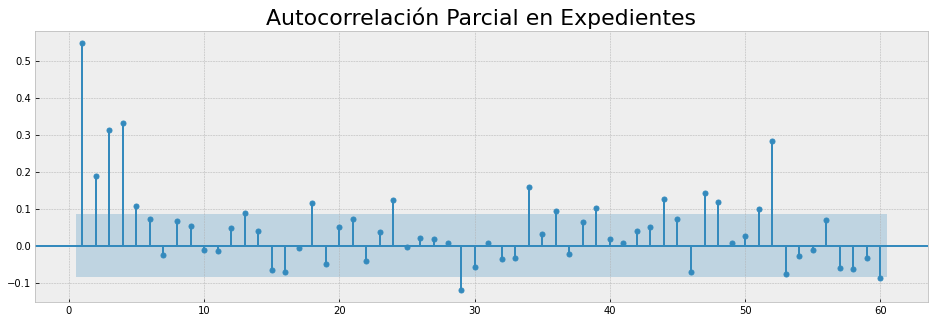

In [25]:
# En el parámetro "method" usamos el métdo de los mínimos cuadrado ordinarios (ols)
#=============================================================================================
sgt.plot_pacf(df_Week.Cant_Expte, lags = 60, zero = False, method = ('ols'))
plt.title("Autocorrelación Parcial en Expedientes", size = 22);

#### Conclusiones
- Vemos el área azul y concluimos que solo los primeros elementos son sinificativamente distintos de 0
- Hay un gran contraste con el gráfico de autocorrelación de nuestra serie de tiempo, donde casi todos los elementos eran sinificativos
- Tambien vemos valores negativos. Por ejemplo el valor negativo ubicado en el 25 significa que los valores de la cantidad de expedientes más altos hace 25 días resultan en valores de cantidad de expedientes más bajos o viceversa
- La  forma en que este método funciona es cancelando todos los canales adicionales que vimos en los que un valor de un periodo anterior afecta indirectamente al valor presente
- Vemos que los valores de ambas gráficas para el primer retraso son idénticos. Esto se debe a que no hay otros canales a través de los cuales los valores pasados pueden afectar a los valores actuales 

## Autocorrelación Parcial del Ruido Blanco

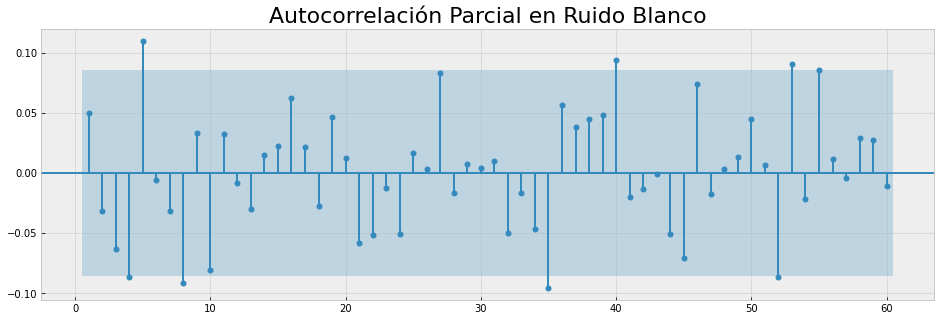

In [26]:
# Aplicamos el paquete Statsmodels en Python para determinar la autocorrelación parcial del ruido blanco
#=============================================================================================
sgt.plot_pacf(df_Week.rb, lags = 60, zero = False, method = ('ols'))
plt.title("Autocorrelación Parcial en Ruido Blanco", size = 22);

#### Conclusiones
- Como hemos visto en la gráfica anterior "Autocorrelación para el Ruido Blanco", tampoco hay autocorrelación parcial para ningún retraso, lo cual es uno de los supuestos del ruido blanco

In [ ]:
################ Ver 46. Visualizando Patrones######################## 